### Matplotlib second introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

""" We read: https://matplotlib.org/stable/tutorials/intermediate/artists.html
    It explains basic "who is who" in matplotlib"""

' We read: https://matplotlib.org/stable/tutorials/intermediate/artists.html\n    It explains basic "who is who" in matplotlib'

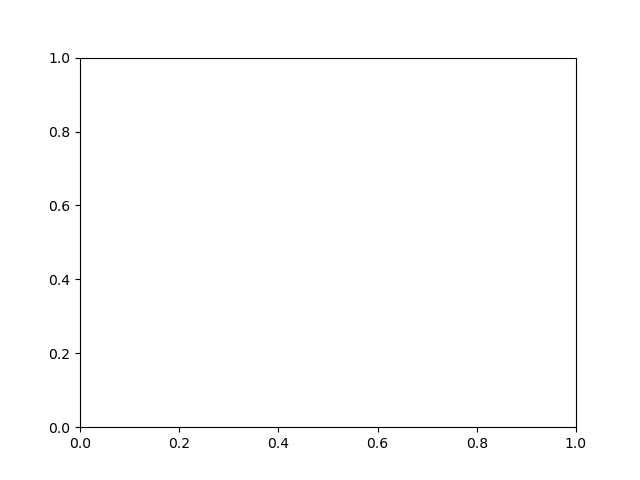

In [8]:
# %matplotlib widget

fig, ax = plt.subplots()

(-1.0, 1.5)

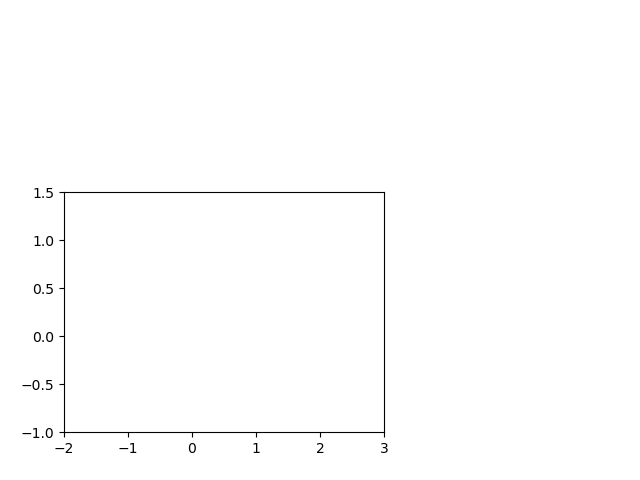

In [23]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1, 0.1, 0.5, 0.5])

# set the (inner) limits.
ax2.set_xlim([-2, 3])
ax2.set_ylim([-1, 1.5])



(-1.0, 1.5)

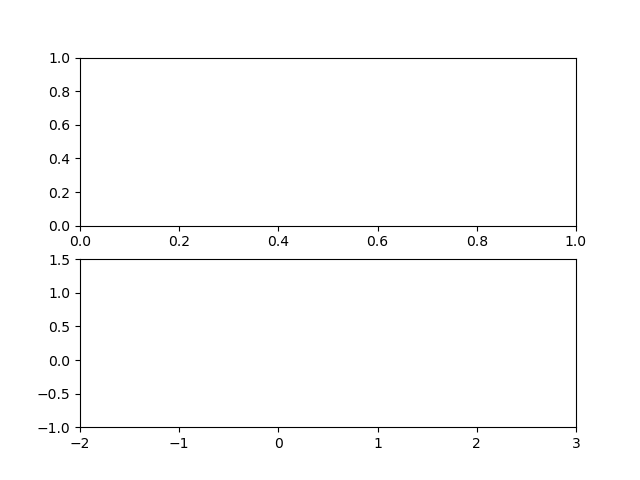

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()


ax = fig.add_subplot(2, 1, 1)

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim([-2, 3])
ax2.set_ylim([-1, 1.5])

### Birds with time on slider

In [2]:
""" Creating birds data."""
import numpy as np
from numpy.random import default_rng, SeedSequence

### initial condition functions ###
def set_random_y0(N, seed, low=0, high=1, velo_st_dev=4):
    """Produces an initial CS_matrix"""
    rng = default_rng(SeedSequence(seed))
    
    x_s = rng.uniform(low=low, high=high, size=N) # x coordinates of intial position
    y_s = rng.uniform(low=low, high=high, size=N) # y coordinates of intial position

    vx_s = velo_st_dev*rng.standard_normal(N) # x coordinates of intial velocity
    vy_s = velo_st_dev*rng.standard_normal(N) # y coordinates of intial velocity

    y_0 = np.c_[x_s, y_s, vx_s, vy_s] #returns a CS_matrix - initial condition
    return y_0

n = 50
def comm_weight(s):
    """Communication weight in Cucker-Smale model"""
    return 0.5*np.float_power(s, -0.01, out=np.zeros_like(s), where=s!=0)

from typing import Callable

def rhs_func(t: float, y: np.ndarray, mass: np.ndarray, comm_weight: Callable)-> np.ndarray:
    """ The splitting of dx and dv is done here. 
            t           : independent variable in the ODE
            y           : CS_data_point of the shape (N*4,)
            mass        : array of "masses" we can set that some birds are more important than other
            comm_weight : callable 'communication weight' funtion
        """
    def rhs_d_pos(y):
        u = y.copy()
        u[:,0], u[:,1] = 0, 0    # zeroing the position
        return u[:,[2,3,0,1]]    # velocities go to the front

    def rhs_d_vel(y, mass=0, comm_weight=0):
        """ docs """
        #split position and velocity
        N = len(y)
        vel = y.copy()
        vel[:,0], vel[:,1] = 0, 0
        pos = y.copy()
        pos[:,2], pos[:,3] = 0, 0

        # stack of matricies of all diferences of velocities
        vel_diff = np.stack([vel]*N,axis=0) - np.stack([vel]*N,axis=1)

        # stack of matricies of all diferences of position
        pos_diffs = np.stack([pos]*N,axis=0) - np.stack([pos]*N,axis=1)

        # the values of eta function on distances 
        vcomm_weight = np.vectorize(comm_weight)
        weighted_diffs = vcomm_weight(np.linalg.norm(pos_diffs, axis=2, keepdims=True))

        return np.sum( weighted_diffs*vel_diff, axis=1 )

    # N = len(y)
    y = y.reshape(-1,4)    # this is for technical reasons = solve_ivp was not working for me with the .shape =(N, 4) so i'm using .shape=(N*4,)
    x_derivatives = rhs_d_pos(y)
    y_derivatives = rhs_d_vel(y, mass, comm_weight)
    rhs = x_derivatives + y_derivatives
    return rhs.ravel()

y0 = set_random_y0(n,12346)

from scipy.integrate import solve_ivp
birds = solve_ivp(lambda t, y: rhs_func(t , y, 0, comm_weight),
        (0, 0.2),
        y0.ravel(),
        method='RK45',
        # t_eval = np.linspace(self.t0, self.t0+self.duration, int(self.duration*self.fps/self.speed)),
        dense_output=True
        )
birds.message

'The solver successfully reached the end of the integration interval.'

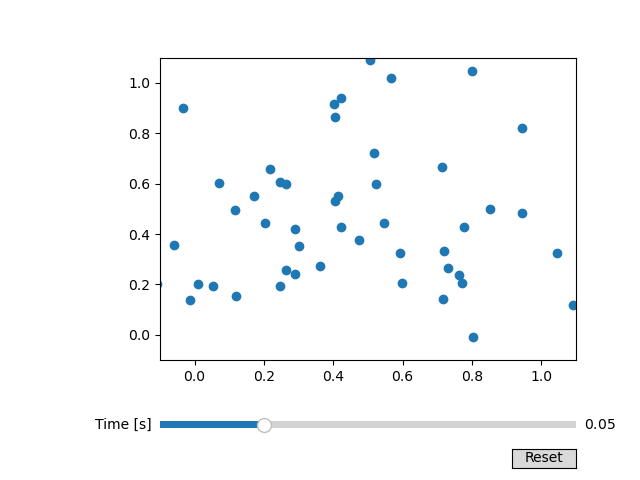

In [88]:
""" drawing birds example """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# Define initial parameter
init_time = 0.05

# Create the figure and the points that we will manipulate
fig, ax = plt.subplots()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
bird_points = plt.scatter(*(birds.sol(init_time).reshape(-1,4)[:,:2].T))

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the time.
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax = axtime,
    label='Time [s]',
    valmin=0,
    valmax=0.2,
    valinit=init_time,
)

# The function to be called anytime a slider's value changes
def update(val):
    bird_points.set_offsets(birds.sol(time_slider.val).reshape(-1,4)[:,:2])
    fig.canvas.draw_idle()

# register the update function with each slider    
time_slider.on_changed(update)

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    time_slider.reset()
button.on_clicked(reset)

plt.show()

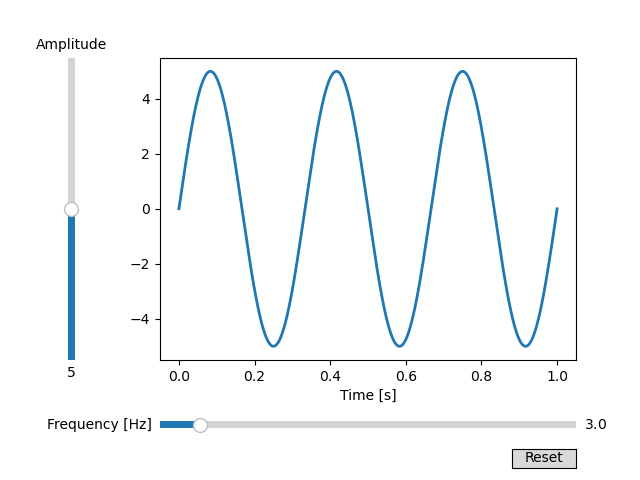

In [89]:
""" matplotlib sliders example from https://matplotlib.org/stable/gallery/widgets/slider_demo.html """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

### Animation

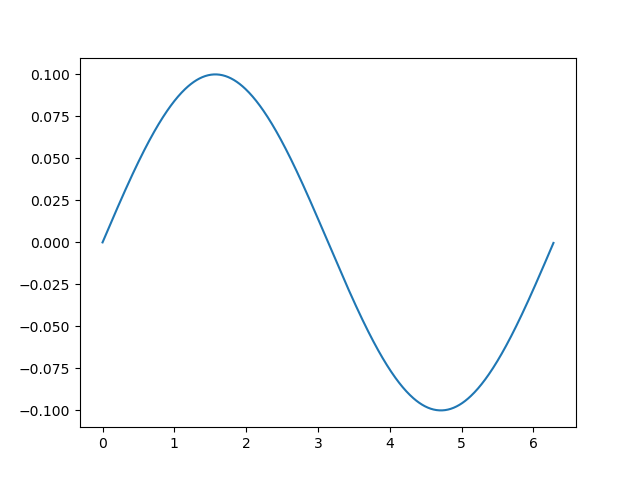

In [10]:
""" Again start with an example from docs from the page:
        https://matplotlib.org/stable/api/animation_api.html 
    there an example- animated line plot:
        https://matplotlib.org/stable/gallery/animation/simple_anim.html
    """
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x)*0.1)


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

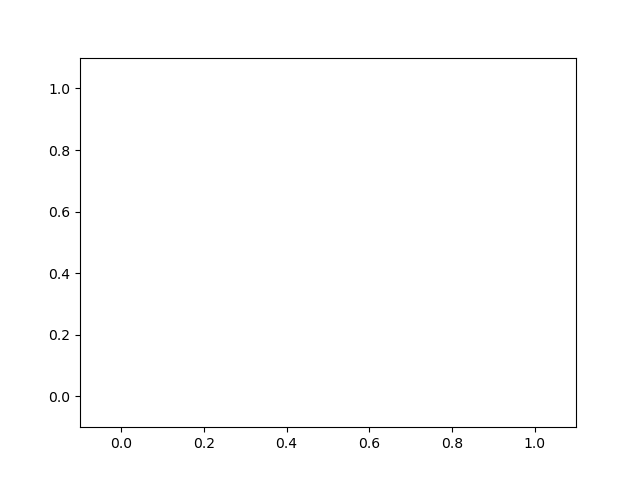

In [4]:
""" Change the example to fit our problem """
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and the points that we will animate
fig, ax = plt.subplots()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

# birds_anim = plt.scatter(*(birds.sol(0).reshape(-1,4)[:,:2].T))
birds_anim = plt.scatter([],[])

def animate(i):
    birds_anim.set_offsets(birds.sol(i).reshape(-1,4)[:,:2])  # update the data.
    return birds_anim,

# frames of the future animation
ani_frames = np.linspace(0,0.2,200)

ani = animation.FuncAnimation(
    fig, animate, interval=40, blit=False, frames = ani_frames, repeat = False)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()